# Alzheimer's Prediction (Multi-Class) 
* See [Alzheimer's Prediction](https://github.com/grantgasser/Alzheimers-Prediction) for a summary of this project

### Variable Descriptions
* `directory.id`	Id assigned to imaging directories. Not from LONi data
* `Subject (PTID)`	Participant ID
* `RID`	Participant roster ID
* `Image.Data.ID`	MRI ID
* `Modality`	Image type
* `Visit`	1=screening scan
* `Acq.Date`	MRI date
* `DX.bl`	Diagnosis at baseline
* `EXAMDATE`	Examination Date
* `AGE`	    Age at baseline
* `PTGENDER`	Sex
* `PTEDUCAT`	Years of Education
* `PTETHCAT`	Ethnicity
* `PTRACCAT`	Race
* `APOE4`	APOE4 genotype
* `MMSE`	MMSE score on cognitive test
* `imputed_genotype`	Challenge specific designation, TRUE=has imputed genotypes
* `APOE Genotype`	APOE allele 1 and allele 2 genotypes
* `Dx Codes for Submission`	The LMCI in the ADNI data is equivalent to MCI in test. This column just converts LMCI->MCI

# Note: This notebook is being refactored
* More EDA
* Proper train/test split 
* Use **AUC** as main metric for evaluation as well as **Accuracy**

In [68]:
import numpy as np
import sklearn as sk
import pandas as pd
import os

In [69]:
#Read data
dat = pd.read_csv('ADNI_Training_Q3_APOE_CollectionADNI1Complete 1Yr 1.5T_July22.2014.csv')

#Check NA values, 1 NA for imputed_genotype
# dat.isnull().sum()

### Remove NA

In [70]:
dat = dat.dropna()
dat.isnull().sum().sum()

0

In [71]:
#Peek at data
dat.head(3)

,directory.id,Subject,RID,Image.Data.ID,Modality,Visit,Acq.Date,DX.bl,EXAMDATE,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,APOE4,MMSE,imputed_genotype,APOE Genotype,Dx Codes for Submission
0,4702245ea294ce5d4e9b8a87027dfdf4,011_S_0003,3,32237,MRI,1,09-01-2005,AD,09-12-2005,81.3,Male,18,Not Hisp/Latino,White,1,20,True,"3,4",AD
1,2e89e352af743597b2368c412e0f6de2,022_S_0004,4,64631,MRI,1,9/22/05,LMCI,11-08-2005,67.5,Male,10,Hisp/Latino,White,0,27,False,"3,3",MCI
2,90419199306997753de8042f1fd55e38,011_S_0005,5,32246,MRI,1,09-02-2005,CN,09-07-2005,73.7,Male,16,Not Hisp/Latino,White,0,29,True,"3,3",CN


### Remove ID's and other features

In [72]:
X = dat
Y = dat['DX.bl']
del dat

#Remove unnecessary columns (features), remove first 9 columns and 'Dx codes for submission'
remove_columns = list(X.columns)[0:9]
remove_columns.append('Dx Codes for Submission')
print('Removing columns:', remove_columns)

X = X.drop(remove_columns, axis=1)

features = list(X.columns)
X.columns = X.columns.astype(str)
X.head(5)

Removing columns: ['directory.id', 'Subject', 'RID', 'Image.Data.ID', 'Modality', 'Visit', 'Acq.Date', 'DX.bl', 'EXAMDATE', 'Dx Codes for Submission']


,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,APOE4,MMSE,imputed_genotype,APOE Genotype
0,81.3,Male,18,Not Hisp/Latino,White,1,20,True,"3,4"
1,67.5,Male,10,Hisp/Latino,White,0,27,False,"3,3"
2,73.7,Male,16,Not Hisp/Latino,White,0,29,True,"3,3"
3,80.4,Female,13,Not Hisp/Latino,White,0,25,True,"3,3"
4,73.9,Female,12,Not Hisp/Latino,White,1,24,True,"3,4"


In [73]:
X = X[X.columns].map(str)
# X.columns = X.columns.astype('string')
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 627 entries, 0 to 627
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   AGE               627 non-null    object
 1   PTGENDER          627 non-null    object
 2   PTEDUCAT          627 non-null    object
 3   PTETHCAT          627 non-null    object
 4   PTRACCAT          627 non-null    object
 5   APOE4             627 non-null    object
 6   MMSE              627 non-null    object
 7   imputed_genotype  627 non-null    object
 8   APOE Genotype     627 non-null    object
dtypes: object(9)
memory usage: 49.0+ KB


## Exploratory Data Analysis (EDA)

In [74]:
numerical_vars = ['AGE', 'MMSE', 'PTEDUCAT']
cat_vars = list(set(features) - set(numerical_vars))

print('Categorical variable distributions:\n')

for var in cat_vars:
    print('\nDistribution of', var)
    
    print(X[var].value_counts())

Categorical variable distributions:


Distribution of imputed_genotype
imputed_genotype
True     466
False    161
Name: count, dtype: int64

Distribution of APOE Genotype
APOE Genotype
3,3    275
3,4    221
4,4     71
2,3     45
2,4     13
2,2      2
Name: count, dtype: int64

Distribution of PTRACCAT
PTRACCAT
White    583
Black     31
Asian     13
Name: count, dtype: int64

Distribution of PTETHCAT
PTETHCAT
Not Hisp/Latino    616
Hisp/Latino          8
Unknown              3
Name: count, dtype: int64

Distribution of PTGENDER
PTGENDER
Male      363
Female    264
Name: count, dtype: int64

Distribution of APOE4
APOE4
0    322
1    234
2     71
Name: count, dtype: int64


#### Categorical Var Distribution Notes
* Ethnicity and Race are separate vars
* Distribution of Hispanic, Black, White, Asian not quite same as overall American ethnic/racial distribution
* APOE Genotype with 3 in the first spot seems to be overwhelming majority `3,3` and `3,4`
* More males in study than females

### Numerical Variable Distributions
* All 3 distributions seem a bit right-skewed
* **Age**: `mean = 75`, `min=55`, `max=89` - seems to be no obvious bad data
* **MMSE**: `mean = 26.9`, `min=20`, `max=30` - seems to be no obvious bad data, NOTE: MMSE $\in ~(0,30)$
* **PTEDUCAT**: `mean = 15.6`, `min=6`, `max=20` - seems to be no obvious bad data. 13-14 yrs is probably high school/GED and 17-18 years is likely Bachelor's degree

Numerical Var Distributions:



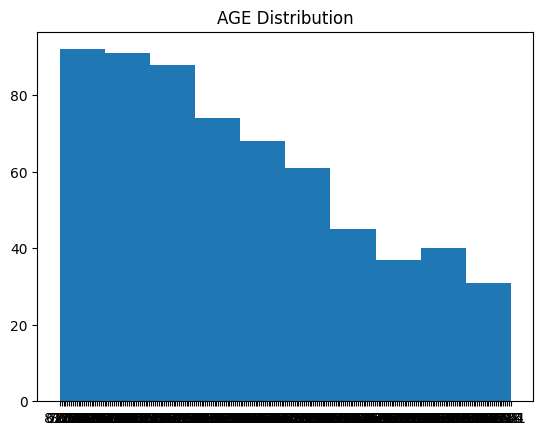

count      627
unique     243
top       70.6
freq         9
Name: AGE, dtype: object


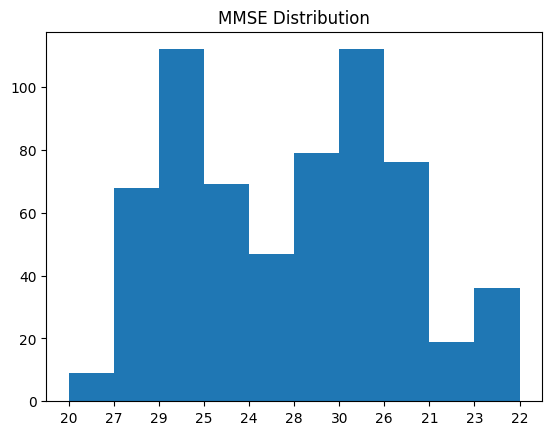

count     627
unique     11
top        29
freq      112
Name: MMSE, dtype: object


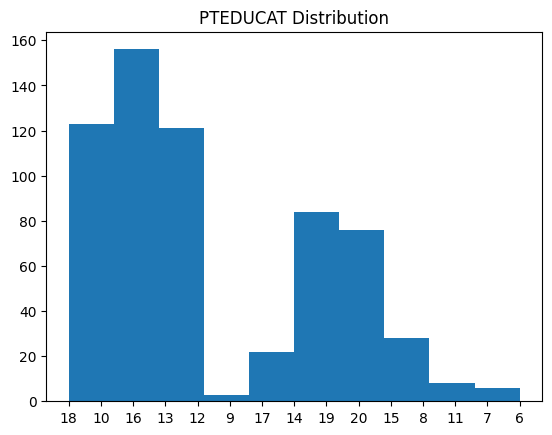

count     627
unique     15
top        16
freq      156
Name: PTEDUCAT, dtype: object


In [75]:
from matplotlib import pyplot as plt
%matplotlib inline

print('Numerical Var Distributions:\n')

for var in numerical_vars:
    plt.hist(X[var], bins=10)
    plt.title(var + ' Distribution')
    plt.show()
    
    # descriptive stats
    print(X[var].describe())

### Analyze target (y) distribution
* High number (304) of limited impairment (LMCI). Maybe old age? Or the patients being evaluated are not random elderly patients but patients already known to have cognitive issues.

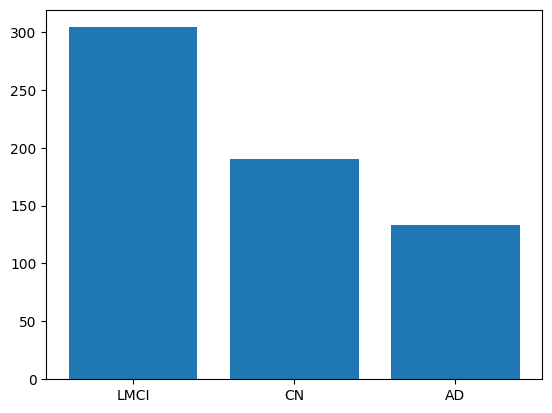

In [76]:
plt.bar(Y.value_counts().index, Y.value_counts())
plt.show()

## Pre-processing

### Convert Categorical Variables to 1-Hot
* Next time use `sklearn.preprocessing.OneHotEncoder`

In [77]:
#for each categorical var, convert to 1-hot encoding
for var in cat_vars:
    print('Converting', var, 'to 1-hot encoding')
    
    #get 1-hot and replace original column with the >= 2 categories as columns
    one_hot_df = pd.get_dummies(X[var])
    X = pd.concat([X, one_hot_df], axis=1)
    X = X.drop(var, axis=1)
    
X.head(4)

Converting imputed_genotype to 1-hot encoding
Converting APOE Genotype to 1-hot encoding
Converting PTRACCAT to 1-hot encoding
Converting PTETHCAT to 1-hot encoding
Converting PTGENDER to 1-hot encoding
Converting APOE4 to 1-hot encoding


,AGE,PTEDUCAT,MMSE,False,True,"2,2","2,3","2,4","3,3","3,4",...,Black,White,Hisp/Latino,Not Hisp/Latino,Unknown,Female,Male,0,1,2
0,81.3,18,20,False,True,False,False,False,False,True,...,False,True,False,True,False,False,True,False,True,False
1,67.5,10,27,True,False,False,False,False,True,False,...,False,True,True,False,False,False,True,True,False,False
2,73.7,16,29,False,True,False,False,False,True,False,...,False,True,False,True,False,False,True,True,False,False
3,80.4,13,25,False,True,False,False,False,True,False,...,False,True,False,True,False,True,False,True,False,False


### Remember:
* PTGENDER: (Male, Female)
* PTETHCAT: (Hisp/Latino, Not Hisp/Latino, Unknown)
* PTRACCAT: (White, Black, Asian)
* APOE4: (0, 1, 2)
* APOE4 Genotype: (22, 23, 24, 33, 34, 44)
* imputed_genotype (True, False)

### Normalization code if necessary (for neural network)
* Could also use from `sklearn.preprocessing` `StandardScaler` or `Normalizer` or `MinMaxScaler`

In [78]:
def normalize(X):
    """
    Normalize numerical variables for faster and better convergence
    
    Args:
        X (pd.DataFrame): data
        
    Returns:
        X (numpy array): same data but with normalized numerical features
    """

    #Convert to numpy array
    X = np.array(X)
    sanity_check = 0

    #Normalize numerical variables to speed up convergence
    for i in range(3):
        mean = np.mean(X[:, i])
        sd = np.std(X[:, i])
        print('\nNormalizing', numerical_vars[i], 'with mean=', format(mean, '.2f'), 'and sd=', format(sd, '.2f'))

        X[:, i] = (X[:, i] - mean) / sd
        sanity_check += np.mean(X[:, i])

    print('\nSanity Check. Sum of all the means should be near 0:', sanity_check)

    # X.columns = X.columns.astype(str)

    return X

## Train/Test Split
* `X_train` and `y_train` will further split into train/valid splits using K-fold CV
* `X_test` and `y_test` will be held out

In [79]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)

print('X_train:', X_train.shape, '\ty_train:', y_train.shape)
print('X_test:', X_test.shape, '\ty_test:', y_test.shape)
num_test = X_test.shape[0]

X_train: (501, 22) 	y_train: (501,)
X_test: (126, 22) 	y_test: (126,)


## Logistic Regression, Random Forest, KNN, MLP

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score

In [81]:
log_clf = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=1000000, multi_class='multinomial')
print('Validation Accuracy = ', format(cross_val_score(log_clf, X_train, y_train, cv=5).mean(), '.2%'))

Validation Accuracy =  69.27%


In [82]:
rf_clf = RandomForestClassifier(n_estimators=200)
print('Validation Accuracy = ', format(cross_val_score(rf_clf, X_train, y_train, cv=5).mean(), '.2%'))

Validation Accuracy =  65.68%


In [83]:
knn_clf = KNeighborsClassifier(n_neighbors=10)
print('Validation Accuracy = ', format(cross_val_score(knn_clf, X_train, y_train, cv=5).mean(), '.2%'))

Validation Accuracy =  67.06%


In [84]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(15, 10), alpha=3, learning_rate='adaptive', max_iter=100000)
print('Validation Accuracy = ', format(cross_val_score(mlp_clf, X_train, y_train, cv=5).mean(), '.2%'))

Validation Accuracy =  47.07%


### Tangent: Evaluate feature importances given by Random Forest

### Remember:
* PTGENDER: (Male, Female)
* PTETHCAT: (Hisp/Latino, Not Hisp/Latino, Unknown)
* PTRACCAT: (White, Black, Asian)
* APOE4: (0, 1, 2)
* APOE4 Genotype: (22, 23, 24, 33, 34, 44)
* imputed_genotype (True, False)

In [85]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [86]:
# https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
feature_importances = pd.DataFrame(rf_clf.feature_importances_, index=X_train.columns, 
                                   columns=['Importance']).sort_values('Importance', ascending=False)
print(feature_importances[:10])

          Importance
MMSE        0.377471
AGE         0.291844
PTEDUCAT    0.152709
0           0.018761
Male        0.018382
Female      0.017881
True        0.015835
False       0.015318
3,3         0.011258
2,3         0.010967


### Conclusion: Feature Importance
* Cognitive test score (MMSE), age (AGE), years of education (PTEDUCAT) are considered the three most important features by far
* Interestingly, the genetic information (APOE4 and APOE4 Genotype) was not considered very important by the model

## Model Selection

### Choosing Logistic Regression
* `Validation Score = .69` - unable to take advantage of more complex models, likely due to small data set size

### Test Logistic Regression Model
* `Test Score = .746` - take with a grain of salt since validation score was `.69`

In [87]:
log_clf.fit(X_train, y_train)

log_clf_preds = log_clf.predict(X_test)
    
log_clf_accuracy = (log_clf_preds == y_test)
print('Test Accuracy =', format( np.sum(log_clf_accuracy)/num_test, '.2%'))

Test Accuracy = 73.02%


### Analyze misclassifications

In [88]:
misclassified_index = (log_clf_preds != y_test)

X_misclassified = X_test[misclassified_index]
y_misclassified = y_test[misclassified_index]
preds_misclassified = log_clf_preds[misclassified_index]

X_misclassified.head()

,AGE,PTEDUCAT,MMSE,False,True,"2,2","2,3","2,4","3,3","3,4",...,Black,White,Hisp/Latino,Not Hisp/Latino,Unknown,Female,Male,0,1,2
573,59.9,16,25,False,True,False,False,False,False,True,...,False,True,False,True,False,False,True,False,True,False
448,78.5,12,26,False,True,False,False,False,False,True,...,False,True,False,True,False,True,False,False,True,False
341,82.0,16,24,False,True,False,False,False,False,True,...,False,True,False,True,False,True,False,False,True,False
459,70.7,13,26,False,True,False,False,False,True,False,...,False,True,False,True,False,True,False,True,False,False
424,70.0,10,28,True,False,False,False,False,True,False,...,False,True,False,True,False,True,False,True,False,False


In [89]:
print('Pred'.ljust(5), 'Y')
print('-----------')

over_estimate = under_estimate = total_miss = 0
for pred, y in zip(preds_misclassified, y_misclassified):
    print(pred.ljust(5), y)
    
    if (y == 'CN' and pred == 'AD') or (y == 'AD' and pred == 'CN'):
        total_miss += 1
    
    if y == 'CN':
        over_estimate += 1
        
    elif y == 'AD':
        under_estimate += 1
    
    # y is 'LMCI'
    else:
        if pred == 'CN':
            under_estimate += 1
        elif pred == 'AD':
            over_estimate += 1

Pred  Y
-----------
LMCI  AD
LMCI  AD
AD    LMCI
LMCI  AD
LMCI  CN
LMCI  CN
AD    LMCI
LMCI  CN
LMCI  CN
AD    LMCI
LMCI  CN
CN    LMCI
LMCI  AD
LMCI  CN
CN    LMCI
LMCI  CN
AD    LMCI
LMCI  CN
CN    LMCI
LMCI  AD
LMCI  AD
LMCI  CN
CN    LMCI
LMCI  AD
AD    LMCI
LMCI  CN
LMCI  AD
LMCI  AD
CN    LMCI
CN    LMCI
LMCI  AD
CN    LMCI
CN    LMCI
LMCI  CN


In [90]:
print('Model over-estimated severity of cognitive problems:', over_estimate)
print('Model under-estimated severity of cognitive problems:', under_estimate)
print('Model was way off (total miss):', total_miss)

Model over-estimated severity of cognitive problems: 16
Model under-estimated severity of cognitive problems: 18
Model was way off (total miss): 0


### Conclusion
* Fairly even misclassification, No total misses
* Probably want to **lower** `under-estimated`. Would be willing to sacrifice accuracy to get a more conservative model.
* e.g. **False Negative:** Predicting cognitively normal (CN) when a patient has Alzheimer's (AD) would be much worse than predicting AD when a patient is normal (CN).

### Look at distribution of 3 most important vars: AGE, MMSE, PTEDUCAT in misclassified examples
* means for entire dataset = `75, 26.9, 15.6`
* distributions looks relatively similar to that of entire data set. No obvious discrepancy 

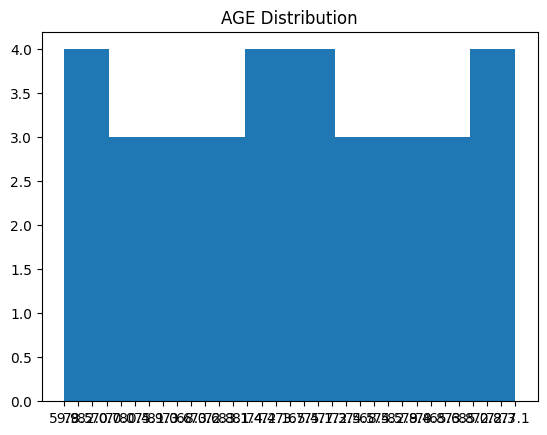

count       34
unique      33
top       72.1
freq         2
Name: AGE, dtype: object


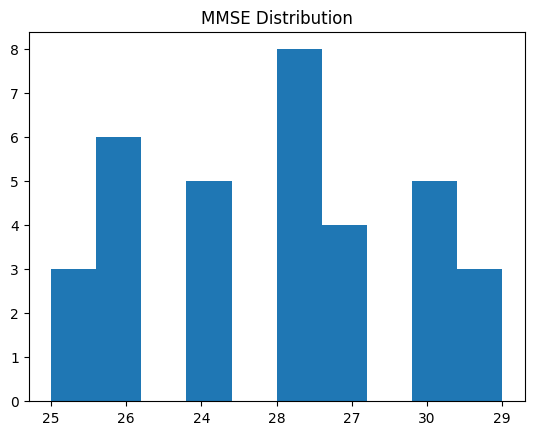

count     34
unique     7
top       28
freq       8
Name: MMSE, dtype: object


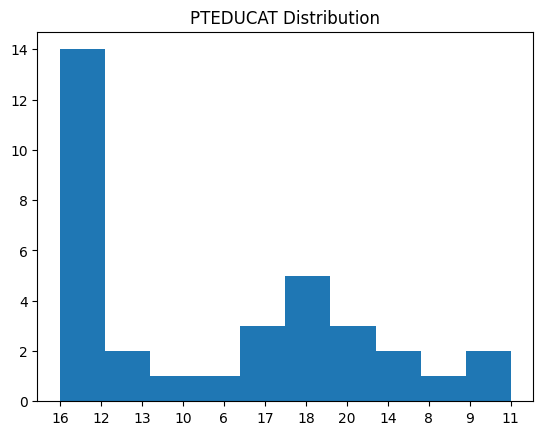

count     34
unique    12
top       16
freq      10
Name: PTEDUCAT, dtype: object


In [91]:
# DRY unless you're a data scientist
for var in ['AGE', 'MMSE', 'PTEDUCAT']:
    plt.hist(X_misclassified[var], bins=10)
    plt.title(var + ' Distribution')
    plt.show()
    
    # descriptive stats
    print(X_misclassified[var].describe())

## TODO
* Evaluate probability predictions from log regr model
* Go back and see if we can remove outliers
* Switch to binary classificiation (so map CN, LMCI => Not AD) so we have classes (Not AD, AD) and use `AUC` as metric
* Or lower log regr. threshold (e.g. .5 => .4) to minimize # of False Negatives